In [5]:
import re
import glob
import pandas as pd

log_dir = "."
log_files = sorted(glob.glob(f"{log_dir}/tp_*.log"))

records = []

# 正则
tp_re = re.compile(r"tp_(\d+)\.log")

train_epoch_re = re.compile(
    r"epoch\s+\d+\s+summary:.*?dyn_sta_loss\s*:\s*([0-9.]+).*?\n"
    r"train loss:\s*([0-9.]+)",
    re.S
)

valid_epoch_re = re.compile(
    r"epoch\s+\d+\s+summary:.*?dyn_sta_loss\s*:\s*([0-9.]+).*?\n"
    r"valid loss:\s*([0-9.]+)",
    re.S
)

for log_path in log_files:
    with open(log_path, "r") as f:
        text = f.read()

    tp = int(tp_re.search(log_path).group(1))

    train_matches = train_epoch_re.findall(text)
    valid_matches = valid_epoch_re.findall(text)

    if not train_matches or not valid_matches:
        print(f"[WARN] skip {log_path}, missing entries")
        continue

    # 只取最后一个 epoch
    train_dyn_sta_loss, train_loss = map(float, train_matches[-1])
    valid_dyn_sta_loss, valid_loss = map(float, valid_matches[-1])

    records.append(dict(
        tp=tp,
        train_dyn_sta_loss=train_dyn_sta_loss,
        train_loss=train_loss,
        valid_dyn_sta_loss=valid_dyn_sta_loss,
        valid_loss=valid_loss,
    ))

df = pd.DataFrame(records).sort_values("tp").reset_index(drop=True)
df


,tp,train_dyn_sta_loss,train_loss,valid_dyn_sta_loss,valid_loss
0,1,0.132182,7.503127,0.13311,8.771914
1,2,0.061172,3.095003,0.06448,4.258434
2,3,0.049620,2.081403,0.04976,3.040179
3,4,0.031311,1.452180,0.03151,2.339852
4,5,0.029008,1.267140,0.02953,2.133759
5,6,0.022759,1.122575,0.02273,1.972882
6,7,0.021535,1.080548,0.02170,1.920972
7,9,0.016139,0.935358,0.01617,1.762224
8,11,0.014829,0.926625,0.01523,1.727702
9,13,0.014501,0.873539,0.01456,1.658985


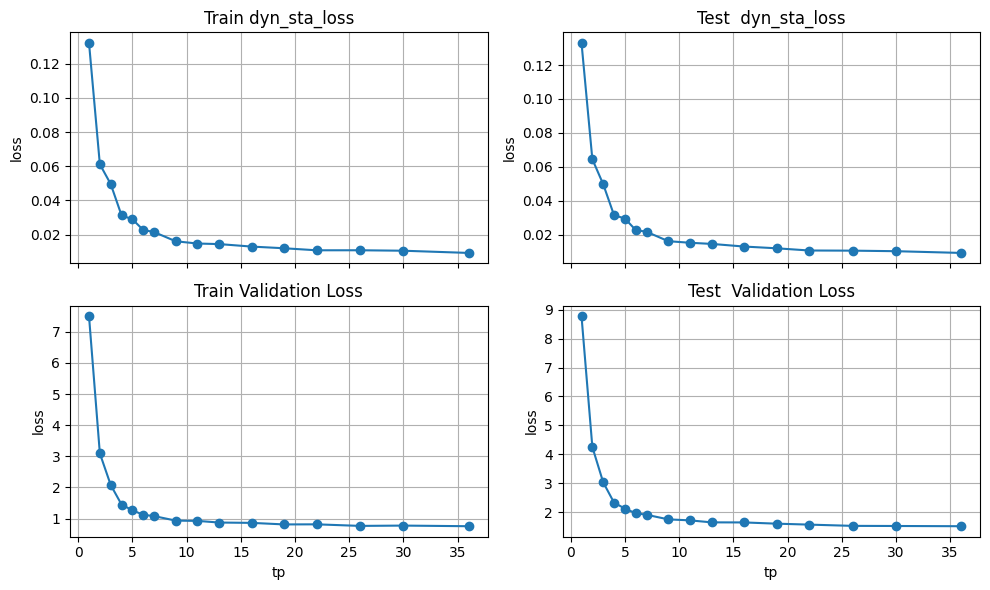

In [6]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(10, 6), sharex=True)

# (row, col): (data column, title, y-label)
plots = {
    (0, 0): ("train_dyn_sta_loss", "Train dyn_sta_loss", "loss"),
    (0, 1): ("valid_dyn_sta_loss", "Test  dyn_sta_loss", "loss"),
    (1, 0): ("train_loss", "Train Validation Loss", "loss"),
    (1, 1): ("valid_loss", "Test  Validation Loss", "loss"),
}

for (i, j), (col, title, ylabel) in plots.items():
    ax = axes[i, j]
    ax.plot(df["tp"], df[col], marker="o")
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.grid(True)

for ax in axes[1]:
    ax.set_xlabel("tp")

plt.tight_layout()
plt.show()
